# 04. Convolutional Neural Networks and Computer Vision with TensorFlow

Now we're going to get specific and see how a special kind of neural network, [convolutional neural networks (CNNs)](https://en.wikipedia.org/wiki/Convolutional_neural_network) can be used for computer vision (detecting patterns in visual data).

> 🔑 **Note:** In deep learning, many different kinds of model architectures can be used for different problems. For example, you could use a convolutional neural network for making predictions on image data and/or text data. However, in practice some architectures typically work better than others.


## What we're going to cover

Specifically, we're going to go through the follow with TensorFlow:

- Getting a dataset to work with
- Architecture of a convolutional neural network
- A quick end-to-end example (what we're working towards)
- Steps in modelling for binary image classification with CNNs
  - Becoming one with the data
  - Preparing data for modelling
  - Creating a CNN model (starting with a baseline)
  - Fitting a model (getting it to find patterns in our data)
  - Evaluating a model
  - Improving a model
  - Making a prediction with a trained model
- Steps in modelling for multi-class image classification with CNNs
 - Same as above (but this time with a different dataset)



## Get the data

The images we're going to work with are from the [Food-101 dataset](https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/), a collection of 101 different categories of 101,000 (1000 images per category) real-world images of food dishes. 

To begin, we're only going to use two of the categories, pizza 🍕 and steak 🥩 and build a binary classifier : **i.e. a subset**.

> 🔑 **Note:** To prepare the data we're using, preprocessing steps such as, moving the images into different subset folders, have been done. To see these preprocessing steps check out [the preprocessing notebook](https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/extras/image_data_modification.ipynb).

We'll download the `pizza_steak` subset .zip file and unzip it.

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf 

In [2]:
import zipfile

# Download zip file of pizza_steak images
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/pizza_steak.zip 

# Unzip the downloaded file
zip_ref = zipfile.ZipFile("pizza_steak.zip", "r")
zip_ref.extractall()
zip_ref.close()

--2022-10-26 11:33:02--  https://storage.googleapis.com/ztm_tf_course/food_vision/pizza_steak.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.12.128, 108.177.13.128, 172.217.193.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.12.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 109540975 (104M) [application/zip]
Saving to: ‘pizza_steak.zip’

pizza_steak.zip     100%[===================>] 104.47M   213MB/s    in 0.5s    

2022-10-26 11:33:03 (213 MB/s) - ‘pizza_steak.zip’ saved [109540975/109540975]



## Inspect the data (become one with it)

A very crucial step at the beginning of any machine learning project is becoming one with the data. This usually means plenty of visualizing and folder scanning to understand the data you're working with.

The file structure has been formatted to be in a typical format you might use for working with images.

More specifically:
* A `train` directory which contains all of the images in the training dataset with subdirectories each named after a certain class containing images of that class.
* A `test` directory with the same structure as the `train` directory.

```
Example of file structure

pizza_steak <- top level folder
└───train <- training images
│   └───pizza
│   │   │   1008104.jpg
│   │   │   1638227.jpg
│   │   │   ...      
│   └───steak
│       │   1000205.jpg
│       │   1647351.jpg
│       │   ...
│   
└───test <- testing images
│   └───pizza
│   │   │   1001116.jpg
│   │   │   1507019.jpg
│   │   │   ...      
│   └───steak
│       │   100274.jpg
│       │   1653815.jpg
│       │   ...    
 ```

Let's inspect each of the directories we've downloaded.

To so do, we can use the command `ls` which stands for list.

In [3]:
!ls pizza_steak

test  train


In [4]:
!ls pizza_steak/train

pizza  steak


In [3]:
import os
from pathlib import Path

pizza_steak_path = Path().cwd() / "pizza_steak"

for path, dir, file in os.walk(pizza_steak_path):
    print(f"There are {len(dir)} directories and {len(file)} images in '{path}'.")

There are 2 directories and 0 images in '/content/pizza_steak'.
There are 2 directories and 0 images in '/content/pizza_steak/train'.
There are 0 directories and 750 images in '/content/pizza_steak/train/pizza'.
There are 0 directories and 750 images in '/content/pizza_steak/train/steak'.
There are 2 directories and 0 images in '/content/pizza_steak/test'.
There are 0 directories and 250 images in '/content/pizza_steak/test/pizza'.
There are 0 directories and 250 images in '/content/pizza_steak/test/steak'.


In [4]:
train_path = pizza_steak_path / "train"

all_items = [item.name for item in train_path.glob("*")]
classe_name = sorted(all_items)
classe_name

['pizza', 'steak']

In [5]:
pizza_train_path = train_path / "pizza"
pizza_train_jpg = [item for item in pizza_train_path.glob("*")]
pizza_train_jpg[:5]

[PosixPath('/content/pizza_steak/train/pizza/3337370.jpg'),
 PosixPath('/content/pizza_steak/train/pizza/394049.jpg'),
 PosixPath('/content/pizza_steak/train/pizza/868789.jpg'),
 PosixPath('/content/pizza_steak/train/pizza/1183278.jpg'),
 PosixPath('/content/pizza_steak/train/pizza/2014717.jpg')]

In [6]:
steak_train_path = train_path / "steak"
steak_train_jpg = [item for item in steak_train_path.glob("*")]
steak_train_jpg[:5]

[PosixPath('/content/pizza_steak/train/steak/1524526.jpg'),
 PosixPath('/content/pizza_steak/train/steak/2287136.jpg'),
 PosixPath('/content/pizza_steak/train/steak/468384.jpg'),
 PosixPath('/content/pizza_steak/train/steak/735441.jpg'),
 PosixPath('/content/pizza_steak/train/steak/286219.jpg')]

In [7]:
train_set_path = steak_train_jpg + pizza_train_jpg
train_set_path[:5], len(train_set_path)

([PosixPath('/content/pizza_steak/train/steak/1524526.jpg'),
  PosixPath('/content/pizza_steak/train/steak/2287136.jpg'),
  PosixPath('/content/pizza_steak/train/steak/468384.jpg'),
  PosixPath('/content/pizza_steak/train/steak/735441.jpg'),
  PosixPath('/content/pizza_steak/train/steak/286219.jpg')],
 1500)

## Visualize image

In [8]:
import matplotlib.image as mpimg
import random
random.seed(0)

def plot_image(i=None, im=None, path=train_set_path):

    if i is None :
        i = random.randint(0, len(path))

    if im is None :
        im = mpimg.imread(path[i])
        im_range = f"{im.min()}-{im.max()}"
        im_classe = path[i].parent.name
    else : 
        im_range = f"{tf.reduce_min(im):.2f}-{tf.reduce_max(im):.2f}"
        im_classe = None
    
    plt.imshow(im)
    plt.title(f"image shape : {im.shape}")
    plt.xlabel(f"image classe : {im_classe}")
    plt.ylabel(f"image value range : {im_range}")
    plt.xticks([])
    plt.yticks([])

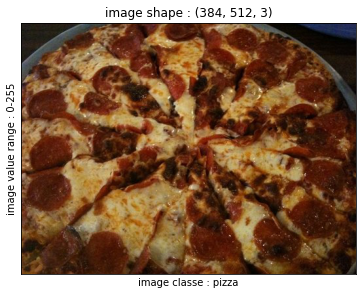

In [11]:
plt.figure(figsize=(6,6))
plot_image()

In [12]:
im_shape = [min(mpimg.imread(train_set_path[i]).shape[0:2]) for i in range(len(train_set_path))]
min_im_shape = min(im_shape)
min_im_shape

254

Looking at the image shape more closely, you'll see it's in the form `(Width, Height, Colour Channels)`.

In our case, the width and height vary but because we're dealing with colour images, the colour channels value is always 3. This is for different values of red, green and blue (RGB) pixels.

All of the values in the `im` array are between 0 and 255. This is because that's the possible range for red, green and blue values.

> 🔑 **Note:** As we've discussed before, many machine learning models, including neural networks prefer the values they work with to be between 0 and 1. Knowing this, one of the most common preprocessing steps for working with images is to **scale** (also referred to as **normalize**) their pixel values by dividing the image arrays by 255.

## A (typical) architecture of a convolutional neural network

Convolutional neural networks are no different to other kinds of deep learning neural networks in the fact they can be created in many different ways. What you see below are some components you'd expect to find in a traditional CNN.


Components of a convolutional neural network:

| **Hyperparameter/Layer type** | **What does it do?** | **Typical values** |
| ----- | ----- | ----- |
| Input image(s) | Target images you'd like to discover patterns in| Whatever you can take a photo (or video) of |
| Input layer | Takes in target images and preprocesses them for further layers | `input_shape = [batch_size, image_height, image_width, color_channels]` |
| Convolution layer | Extracts/learns the most important features from target images | Multiple, can create with [`tf.keras.layers.ConvXD`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D) (X can be multiple values) |
| Hidden activation | Adds non-linearity to learned features (non-straight lines) | Usually ReLU ([`tf.keras.activations.relu`](https://www.tensorflow.org/api_docs/python/tf/keras/activations/relu)) |
| Pooling layer | Reduces the dimensionality of learned image features | Average ([`tf.keras.layers.AvgPool2D`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/AveragePooling2D)) or Max ([`tf.keras.layers.MaxPool2D`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/MaxPool2D)) |
| Fully connected layer | Further refines learned features from convolution layers | [`tf.keras.layers.Dense`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense) |
| Output layer | Takes learned features and outputs them in shape of target labels | `output_shape = [number_of_classes]` (e.g. 3 for pizza, steak or sushi)|
| Output activation | Adds non-linearities to output layer | [`tf.keras.activations.sigmoid`](https://www.tensorflow.org/api_docs/python/tf/keras/activations/sigmoid) (binary classification) or [`tf.keras.activations.softmax`](https://www.tensorflow.org/api_docs/python/tf/keras/activations/softmax) |

How they stack together:

![](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/03-simple-convnet.png)
*A simple example of how you might stack together the above layers into a convolutional neural network. Note the convolutional and pooling layers can often be arranged and rearranged into many different formations.*

---

[`tf.keras.utils.image_dataset_from_directory`](https://www.tensorflow.org/api_docs/python/tf/keras/utils/image_dataset_from_directory)

If your directory structure is:
```
main_directory/
...class_a/
......a_image_1.jpg
......a_image_2.jpg
...class_b/
......b_image_1.jpg
......b_image_2.jpg
```
Then calling `image_dataset_from_directory(main_directory, labels='inferred')` (default value) <br>
will return a `tf.data.Dataset` that yields batches of images from the subdirectories `class_a` and `class_b`, together with labels 0 and 1 <br>
(0 corresponding to `class_a` and 1 corresponding to `class_b`)

In [13]:
from tensorflow.keras.utils import image_dataset_from_directory

train_dir = Path().cwd() / "pizza_steak" / "train/"
test_dir = Path().cwd() / "pizza_steak" / "test/"

train_set = image_dataset_from_directory(train_dir, 
                                         label_mode="binary",
                                         labels='inferred', # 'inferred' by default
                                         batch_size=32, # 32 by default,
                                         shuffle=True, # "True" by default
                                         image_size=(min_im_shape, min_im_shape)) # convert all images to be 254 x 254 (min_im_shape)

test_set = image_dataset_from_directory(test_dir,
                                        label_mode="binary",
                                        image_size=(min_im_shape, min_im_shape))

im = next(train_set.as_numpy_iterator())[0]
im.min(), im.max()

Found 1500 files belonging to 2 classes.
Found 500 files belonging to 2 classes.


(0.0, 255.0)

 **order of the classes => alphanumerical order is used**

`label_mode` ='binary' means that the labels (there can be only 2) are encoded as float32 scalars with values 0 or 1 (e.g. for binary_crossentropy).

[pre-processing layer](https://www.tensorflow.org/guide/keras/preprocessing_layers)


**input_shape = (batch_size,input_dims,channels)**

* Input shape for [Conv1D](https://keras.io/api/layers/convolution_layers/convolution1d/): (batch_size,W,channels) <br> 
>Example: 1 second stereo voice signal sampled at 44100 Hz, shape: (batch_size, 44100, 2)

* Input shape for [Conv2D](https://keras.io/api/layers/convolution_layers/convolution2d/): (batch_size,(H,W),channels) <br>
>Example: 32x32 RGB image, shape: (batch_size, 32, 32, 3)

* Input shape for [Conv3D](https://keras.io/api/layers/convolution_layers/convolution3d/): (batch_size,(H,W,D),channels) <br>
>Example (more tricky): 1 second video of 32x32 RGB images at 24 fps, shape: (batch_size, 32, 32, 24, 3)





## Plotting history

In [27]:
def plot_history(history, zoom=0):
    df = pd.DataFrame(history.history)
    n = len(df.columns)

    row = 1 if n<=3 else n//2
    col = n if n<=3 else n//2 + n%2

    plt.figure(figsize=(5*(col+1) + zoom , 5*row + zoom))
    for i, column in enumerate(df.columns):
        plt.subplot(row, col+1, i+1)
        plt.plot(df[f"{column}"], label=f"{column}")
        plt.legend()
        plt.xlabel("epochs")
        plt.ylabel(f"{column}")
        plt.tight_layout(pad=2) # padding
    
    plt.subplot(row, col+1, n+1)
    for column in df.columns:
        plt.plot(df[f"{column}"], label=f"{column}")
        plt.legend()
    plt.xlabel("epochs")

## Firt **CNN** model

* input layers is in **blue** 
* kernel (3x3) is the shadow part
* output layers is in **green** 
* after that you have the relu activation : each green pixel get through the activator (here `relu` : then if pixel < 0 => 0 else stay same)

![](https://i.stack.imgur.com/0rs9l.gif)

In [15]:
tf.random.set_seed(0)

model_0 = tf.keras.models.Sequential([
    tf.keras.layers.Rescaling(scale=1./255, input_shape=(min_im_shape, min_im_shape, 3)),
    # first layer specifies input shape (height, width, colour channels)

    tf.keras.layers.Conv2D(filters=10, # Integer, the dimensionality of the output space (i.e. the number of output filters in the convolution)
                            kernel_size=3, # can also be (3, 3)
                            activation="relu"), 
    tf.keras.layers.Conv2D(10, 3, activation="relu"),
    tf.keras.layers.MaxPool2D(pool_size=2, # pool_size can also be (2, 2)
                            padding="valid"), # padding can also be 'same'

    tf.keras.layers.Conv2D(10, 3, activation="relu"),
    tf.keras.layers.Conv2D(10, 3, activation="relu"), 
    tf.keras.layers.MaxPool2D(2),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1, activation="sigmoid") # binary activation output
])

model_0.compile(loss="binary_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

model_0.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 254, 254, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 252, 252, 10)      280       
                                                                 
 conv2d_1 (Conv2D)           (None, 250, 250, 10)      910       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 125, 125, 10)     0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 123, 123, 10)      910       
                                                                 
 conv2d_3 (Conv2D)           (None, 121, 121, 10)      910       
                                                        

In [16]:
history_0 = model_0.fit(train_set, validation_data=test_set, epochs=10)

Epoch 1/10
47/47 [==============================] - 17s 120ms/step - loss: 0.5888 - accuracy: 0.6833 - val_loss: 0.4400 - val_accuracy: 0.8120
Epoch 2/10
47/47 [==============================] - 5s 100ms/step - loss: 0.4724 - accuracy: 0.7807 - val_loss: 0.4364 - val_accuracy: 0.8040
Epoch 3/10
47/47 [==============================] - 6s 127ms/step - loss: 0.4557 - accuracy: 0.7833 - val_loss: 0.3775 - val_accuracy: 0.8760
Epoch 4/10
47/47 [==============================] - 5s 100ms/step - loss: 0.3677 - accuracy: 0.8473 - val_loss: 0.3279 - val_accuracy: 0.8700
Epoch 5/10
47/47 [==============================] - 5s 101ms/step - loss: 0.3282 - accuracy: 0.8620 - val_loss: 0.3352 - val_accuracy: 0.8740
Epoch 6/10
47/47 [==============================] - 5s 102ms/step - loss: 0.2449 - accuracy: 0.9033 - val_loss: 0.3645 - val_accuracy: 0.8560
Epoch 7/10
47/47 [==============================] - 5s 100ms/step - loss: 0.1734 - accuracy: 0.9340 - val_loss: 0.3626 - val_accuracy: 0.8560
Epoch

In [17]:
score_0 = model_0.evaluate(test_set)

16/16 [==============================] - 2s 75ms/step - loss: 0.8618 - accuracy: 0.8060


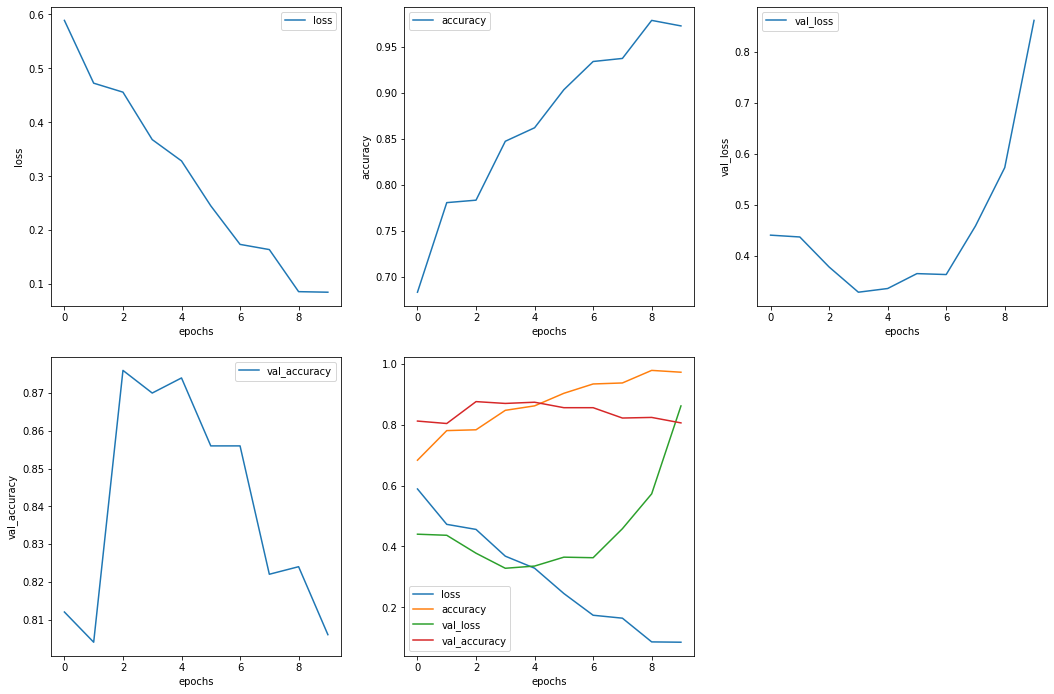

In [18]:
plot_history(history_0)

## Try to improve the model

In [19]:
tf.random.set_seed(0)

model_1 = tf.keras.Sequential([
    tf.keras.layers.Rescaling(scale=1./255, input_shape=(min_im_shape, min_im_shape, 3)),

    tf.keras.layers.Conv2D(filters=10, kernel_size=(3,3), activation="relu"),
    tf.keras.layers.MaxPool2D(pool_size=(2,2)), 
    
    tf.keras.layers.Conv2D(10, (3,3), activation="relu"),
    tf.keras.layers.Conv2D(10, (3,3), activation="relu"),
    tf.keras.layers.MaxPool2D((2,2)),

    tf.keras.layers.Conv2D(10, (3,3), activation="relu"),
    tf.keras.layers.Conv2D(10, (3,3), activation="relu"),
    tf.keras.layers.MaxPool2D((2,2)),

    tf.keras.layers.Conv2D(10, (3,3), activation="relu"),
    tf.keras.layers.Conv2D(10, (3,3), activation="relu"),
    tf.keras.layers.MaxPool2D((2,2)),

    tf.keras.layers.Conv2D(10, (3,3), activation="relu"),
    tf.keras.layers.Conv2D(10, (3,3), activation="relu"),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(32, activation="relu"),
    tf.keras.layers.Dense(32, activation="relu"),
    tf.keras.layers.Dense(32, activation="relu"),
    tf.keras.layers.Dense(32, activation="relu"),
    tf.keras.layers.Dense(32, activation="relu"),
    tf.keras.layers.Dense(32, activation="relu"),
    tf.keras.layers.Dense(1, activation="sigmoid")
])

model_1.compile(loss="binary_crossentropy",
                optimizer="adam",
                metrics=["accuracy"])

In [20]:
history_1 = model_1.fit(train_set, validation_data=test_set, epochs=10)

Epoch 1/10
47/47 [==============================] - 9s 108ms/step - loss: 0.6413 - accuracy: 0.6160 - val_loss: 0.4400 - val_accuracy: 0.8160
Epoch 2/10
47/47 [==============================] - 5s 94ms/step - loss: 0.4876 - accuracy: 0.7780 - val_loss: 0.4177 - val_accuracy: 0.8260
Epoch 3/10
47/47 [==============================] - 5s 95ms/step - loss: 0.4876 - accuracy: 0.7767 - val_loss: 0.3753 - val_accuracy: 0.8440
Epoch 4/10
47/47 [==============================] - 5s 97ms/step - loss: 0.4490 - accuracy: 0.7980 - val_loss: 0.3653 - val_accuracy: 0.8520
Epoch 5/10
47/47 [==============================] - 8s 151ms/step - loss: 0.4177 - accuracy: 0.8153 - val_loss: 0.3714 - val_accuracy: 0.8480
Epoch 6/10
47/47 [==============================] - 5s 97ms/step - loss: 0.4218 - accuracy: 0.8113 - val_loss: 0.3285 - val_accuracy: 0.8620
Epoch 7/10
47/47 [==============================] - 5s 95ms/step - loss: 0.3915 - accuracy: 0.8387 - val_loss: 0.3632 - val_accuracy: 0.8620
Epoch 8/10


In [21]:
score_1 = model_1.evaluate(test_set)

16/16 [==============================] - 1s 44ms/step - loss: 0.2898 - accuracy: 0.8840


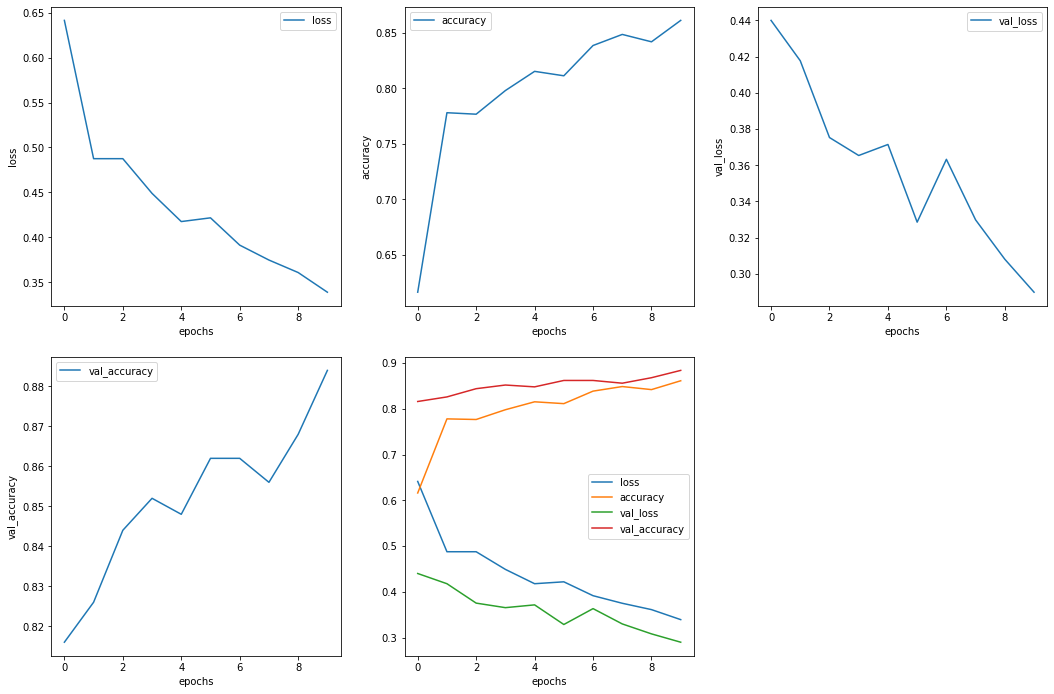

In [22]:
plot_history(history_1)

[CNN explainer website](https://poloclub.github.io/cnn-explainer/)?

Now there are a few new things here we haven't discussed, namely: 

* [`Conv2D`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D) layers (and the parameters which come with them)
* [`MaxPool2D`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/MaxPool2D) layers (and their parameters).
* The `steps_per_epoch` and `validation_steps` parameters in the `fit()` function

Before we dive into each of these, let's see what happens if we try to fit a model we've worked with previously to our data.


---

Ttypical CNN structure :

```
Input -> Conv + ReLU layers (non-linearities) -> Pooling layer 
-> repeat : Conv + ReLU + Pooling 
-> Fully connected (dense layer) as Output
``` 

Let's discuss some of the components of the `Conv2D` layer:

* The "`2D`" means our inputs are two dimensional (height and width), even though they have 3 colour channels, the convolutions are run on each channel invididually.
* `filters` - these are the number of "feature extractors" that will be moving over our images : i.e. numbers of neurons that will go through the image, each neurons has its own kernel.
* `kernel_size` - the size of our filters, for example, a `kernel_size` of `(3, 3)` (or just 3) will mean each filter will have the size 3x3, meaning it will look at a space of 3x3 pixels each time. The smaller the kernel, the more fine-grained features it will extract.
* `stride` - the number of pixels a `filter` will move across as it covers the image. A `stride` of 1 means the filter moves across each pixel 1 by 1. A `stride` of 2 means it moves 2 pixels at a time.
* `padding` - this can be either `'same'` or `'valid'`, `'same'` adds zeros the to outside of the image so the resulting output of the convolutional layer is the same as the input, where as `'valid'` (default) cuts off excess pixels where the `filter` doesn't fit (e.g. 224 pixels wide divided by a kernel size of 3 (224/3 = 74.6) means a single pixel will get cut off the end.

What's a "feature"?

A **feature** can be considered any significant part of an image. For example, in our case, a feature might be the circular shape of pizza. Or the rough edges on the outside of a steak.

It's important to note that these **features** are not defined by us, instead, the model learns them as it applies different filters across the image.

> 📖 **Resources:** For a great demonstration of these in action, be sure to spend some time going through the following:
  * [CNN Explainer Webpage](https://poloclub.github.io/cnn-explainer/) - a great visual overview of many of the concepts we're replicating here with code.
  * [A guide to convolutional arithmetic for deep learning](https://arxiv.org/pdf/1603.07285.pdf) - a phenomenal introduction to the math going on behind the scenes of a convolutional neural network.

## Using the same model as before : DNN (≠CNN)

To examplify how neural networks can be adapted to many different problems, let's see how a binary classification model we've previously built might work with our data.



In [23]:
tf.random.set_seed(0)

model_2 = tf.keras.Sequential([
    tf.keras.layers.Rescaling(scale=1./255, 
                              input_shape=(min_im_shape, min_im_shape, 3)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation="sigmoid"),
])

model_2.compile(loss="binary_crossentropy",
                optimizer="adam",
                metrics=["accuracy"])

history_2 = model_2.fit(train_set, validation_data=test_set, epochs=10)

Epoch 1/10
47/47 [==============================] - 5s 86ms/step - loss: 1.4691 - accuracy: 0.6240 - val_loss: 0.5266 - val_accuracy: 0.7380
Epoch 2/10
47/47 [==============================] - 4s 83ms/step - loss: 0.5380 - accuracy: 0.7500 - val_loss: 0.5744 - val_accuracy: 0.7100
Epoch 3/10
47/47 [==============================] - 4s 83ms/step - loss: 0.5444 - accuracy: 0.7347 - val_loss: 0.4719 - val_accuracy: 0.7760
Epoch 4/10
47/47 [==============================] - 4s 81ms/step - loss: 0.4577 - accuracy: 0.7900 - val_loss: 0.5158 - val_accuracy: 0.7560
Epoch 5/10
47/47 [==============================] - 4s 84ms/step - loss: 0.4509 - accuracy: 0.7947 - val_loss: 0.4431 - val_accuracy: 0.7780
Epoch 6/10
47/47 [==============================] - 4s 82ms/step - loss: 0.5475 - accuracy: 0.7447 - val_loss: 0.5103 - val_accuracy: 0.7480
Epoch 7/10
47/47 [==============================] - 4s 83ms/step - loss: 0.4367 - accuracy: 0.8073 - val_loss: 0.7110 - val_accuracy: 0.6840
Epoch 8/10
47

In [24]:
model_2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 254, 254, 3)       0         
                                                                 
 flatten_2 (Flatten)         (None, 193548)            0         
                                                                 
 dense_8 (Dense)             (None, 64)                12387136  
                                                                 
 dense_9 (Dense)             (None, 64)                4160      
                                                                 
 dense_10 (Dense)            (None, 64)                4160      
                                                                 
 dense_11 (Dense)            (None, 64)                4160      
                                                                 
 dense_12 (Dense)            (None, 64)               

In [25]:
score_2 = model_2.evaluate(test_set)

16/16 [==============================] - 1s 39ms/step - loss: 0.4912 - accuracy: 0.7660


> 🔑 **Note:** You can think of trainable parameters as *patterns a model can learn from data*. Intuitiely, you might think more is better. And in some cases it is. But in this case, the difference here is in the two different styles of model we're using. Where a series of dense layers have a number of different learnable parameters connected to each other and hence a higher number of possible learnable patterns, **a convolutional neural network seeks to sort out and learn the most important patterns in an image**. So even though there are less learnable parameters in our convolutional neural network, these are often more helpful in decphering between different **features** in an image.

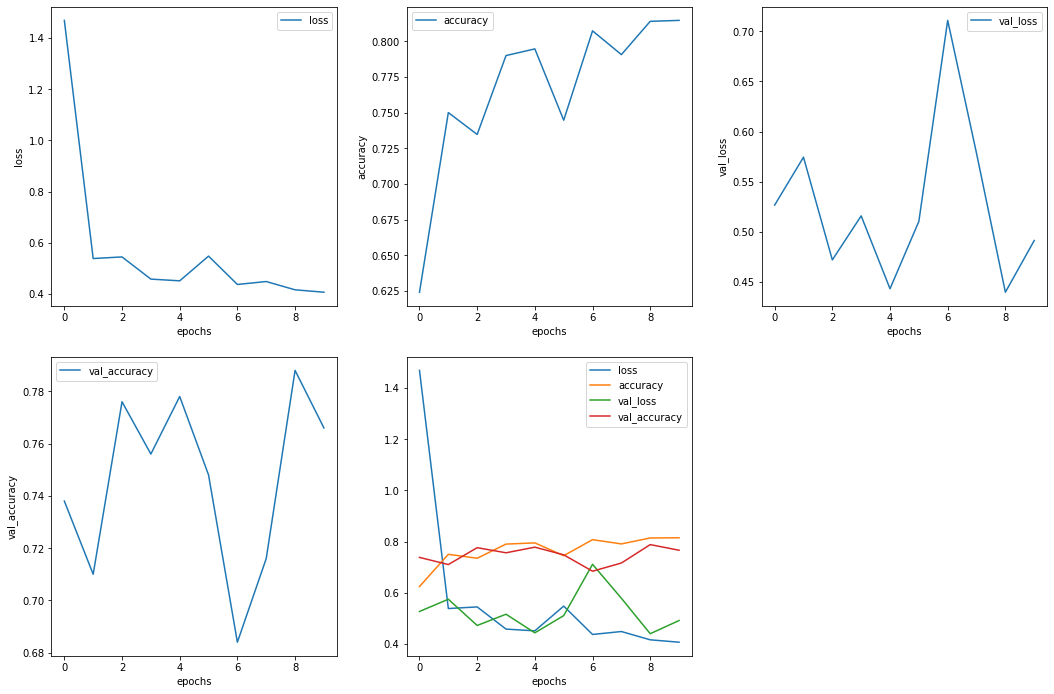

In [26]:
plot_history(history_2)

### Comparing

In [27]:
trainable_variables_0 = tf.reduce_sum([tf.reduce_prod(v.shape) for v in model_0.trainable_variables]).numpy()
trainable_variables_1 = tf.reduce_sum([tf.reduce_prod(v.shape) for v in model_1.trainable_variables]).numpy()
trainable_variables_2 = tf.reduce_sum([tf.reduce_prod(v.shape) for v in model_2.trainable_variables]).numpy()

In [28]:
scores = [["model_0", score_0[1], trainable_variables_0],
          ["model_1", score_1[1], trainable_variables_1],
          ["model_2", score_2[1], trainable_variables_2]]

pd.DataFrame(scores, columns=["model", "test_score", "trainable_variables"])

,model,test_score,trainable_variables
0,model_0,0.806,39011
1,model_1,0.884,33385
2,model_2,0.766,12403841


## How to avoid Overfitting, using data augmentation

**Data augmentation** is the process of altering our training data, leading to it having more diversity and in turn allowing our models to learn more generalizable patterns. Altering might mean adjusting the rotation of an image, flipping it, cropping it or something similar.

Doing this simulates the kind of data a model might be used on in the real world.

If we're building a pizza vs. steak application, not all of the images our users take might be in similar setups to our training data. Using data augmentation gives us another way to prevent overfitting and in turn make our model more generalizable.

> 🔑 **Note 1:** Data augmentation is usally only performed on the training data.

> 🔑 **Note 2:** Preventing overfitting is also referred to as **regularization**.

In [9]:
min_im_shape = 254 #same 

In [10]:
rescale_resize_and_augmentation = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Resizing(min_im_shape, min_im_shape),
  tf.keras.layers.RandomFlip("horizontal_and_vertical"),
  tf.keras.layers.RandomRotation(0.2, fill_mode="constant"), 
  tf.keras.layers.RandomZoom((-0.2, -0.4), fill_mode="constant") # A positive value means zooming out, while a negative value means zooming in
])

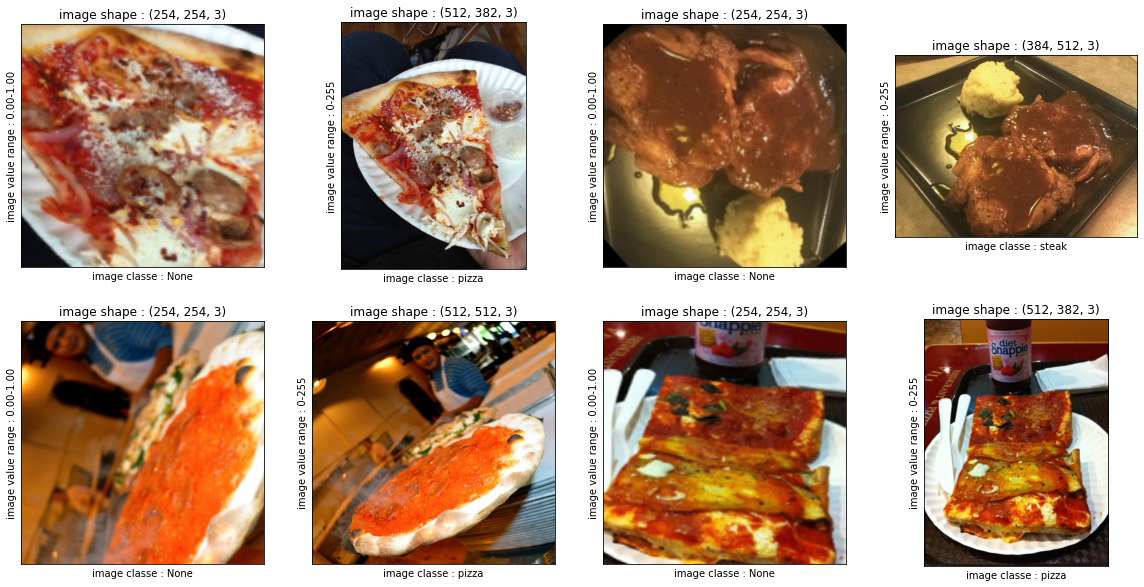

In [11]:
plt.figure(figsize=(20,10))
for k in range(0, 8, 2):
    plt.subplot(2, 4, k+1)
    i = np.random.randint(0, 1500 + 1)
    im = rescale_resize_and_augmentation(mpimg.imread(train_set_path[i]))
    plot_image(i=i, im=im)

    plt.subplot(2, 4, k+2)
    plot_image(i=i)

### Buil a new model like `model_0`

In [32]:
tf.random.set_seed(0)

model_0_data_augmentation = tf.keras.models.Sequential([
    #tf.keras.layers.InputLayer(input_shape=(min_im_shape, min_im_shape, 3)),

    rescale_resize_and_augmentation, # New

    tf.keras.layers.Conv2D(10, kernel_size=3, activation="relu"), 
    tf.keras.layers.Conv2D(10, 3, activation="relu"),
    tf.keras.layers.MaxPool2D(pool_size=2), 

    tf.keras.layers.Conv2D(10, 3, activation="relu"),
    tf.keras.layers.Conv2D(10, 3, activation="relu"), 
    tf.keras.layers.MaxPool2D(2),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1, activation="sigmoid")
])

model_0_data_augmentation.compile(loss="binary_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

In [33]:
history_0_data_augmentation = model_0_data_augmentation.fit(train_set, validation_data=test_set, epochs=10)

Epoch 1/10


47/47 [==============================] - ETA: 0s - loss: 0.5942 - accuracy: 0.6780

47/47 [==============================] - 8s 132ms/step - loss: 0.5942 - accuracy: 0.6780 - val_loss: 0.4714 - val_accuracy: 0.8000
Epoch 2/10
47/47 [==============================] - 7s 128ms/step - loss: 0.5086 - accuracy: 0.7507 - val_loss: 0.4414 - val_accuracy: 0.7980
Epoch 3/10
47/47 [==============================] - 6s 126ms/step - loss: 0.4890 - accuracy: 0.7700 - val_loss: 0.4439 - val_accuracy: 0.7900
Epoch 4/10
47/47 [==============================] - 6s 124ms/step - loss: 0.4557 - accuracy: 0.7960 - val_loss: 0.4044 - val_accuracy: 0.8200
Epoch 5/10
47/47 [==============================] - 6s 122ms/step - loss: 0.4574 - accuracy: 0.7953 - val_loss: 0.4113 - val_accuracy: 0.8160
Epoch 6/10
47/47 [==============================] - 6s 123ms/step - loss: 0.4372 - accuracy: 0.8093 - val_loss: 0.3864 - val_accuracy: 0.8260
Epoch 7/10
47/47 [==============================] - 6s 122ms/step - loss: 0.4434 - accuracy: 0.8027 - val_loss: 0.4318 - val_accuracy: 0.7820
Epoch 8/10
47/47 

### comparing

**with augmentation**

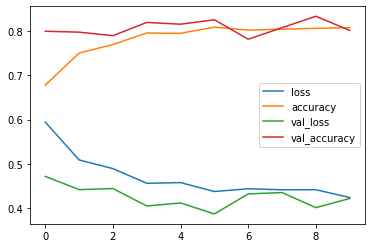

In [34]:
pd.DataFrame(history_0_data_augmentation.history).plot()

**without augmentation**

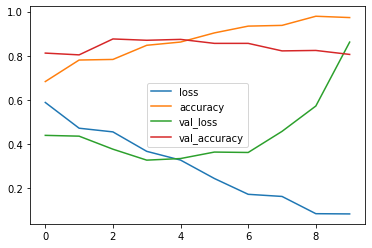

In [35]:
pd.DataFrame(history_0.history).plot()

In [36]:
score_0_data_augmentation = model_0_data_augmentation.evaluate(test_set)

16/16 [==============================] - 1s 48ms/step - loss: 0.4213 - accuracy: 0.8020


In [37]:
train_score_0 = model_0.evaluate(train_set)
train_score_0_data_augmentation = model_0_data_augmentation.evaluate(train_set)

47/47 [==============================] - 3s 63ms/step - loss: 0.4660 - accuracy: 0.7867


In [38]:
scores = [
    ["non-augmentation", train_score_0[1], score_0[1], train_score_0[1]-score_0[1]],
    ["augmentation", train_score_0_data_augmentation[1], score_0_data_augmentation[1], train_score_0_data_augmentation[1]-score_0_data_augmentation[1]]
]

pd.DataFrame(scores, columns=["model_type", "train_score", "test_score", "delta"])

,model_type,train_score,test_score,delta
0,non-augmentation,0.974667,0.806,0.168667
1,augmentation,0.786667,0.802,-0.015333


## Make predition 

To really test it out, we'll upload a couple of internet images and see how the model goes.

### Steak prediction

In [39]:
# View our example image
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/03-steak.jpeg 
steak = mpimg.imread("03-steak.jpeg")

--2022-10-21 11:04:17--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/03-steak.jpeg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1978213 (1.9M) [image/jpeg]
Saving to: ‘03-steak.jpeg’

03-steak.jpeg       100%[===================>]   1.89M  --.-KB/s    in 0.009s  

2022-10-21 11:04:18 (216 MB/s) - ‘03-steak.jpeg’ saved [1978213/1978213]



(4032, 3024, 3)

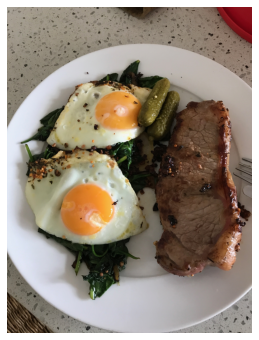

In [40]:
plt.figure(figsize=(6,6))
plt.imshow(steak)
plt.axis(False)
steak.shape

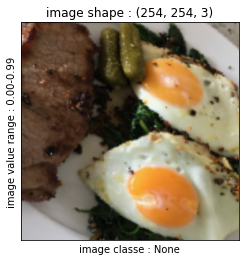

In [41]:
im = rescale_resize_and_augmentation(steak)
plot_image(im=im)

In [42]:
steak_ = tf.expand_dims(steak, axis=0) # batch
prediction = model_0_data_augmentation.predict(steak_)
prediction

1/1 [==============================] - 0s 315ms/step


array([[0.7212479]], dtype=float32)

In [43]:
np.round(prediction)[0, 0]

1.0

In [44]:
classe_name[int(np.round(prediction)[0, 0])]

'steak'

### Pizza prediction

In [45]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/03-pizza-dad.jpeg 
pizza = mpimg.imread("03-pizza-dad.jpeg")

--2022-10-21 11:04:20--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/03-pizza-dad.jpeg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2874848 (2.7M) [image/jpeg]
Saving to: ‘03-pizza-dad.jpeg’

03-pizza-dad.jpeg   100%[===================>]   2.74M  --.-KB/s    in 0.008s  

2022-10-21 11:04:21 (323 MB/s) - ‘03-pizza-dad.jpeg’ saved [2874848/2874848]



In [46]:
pizza_ = tf.expand_dims(pizza, axis=0) # batch
prediction = model_0_data_augmentation.predict(pizza_)
classe_name[int(np.round(prediction)[0, 0])]

1/1 [==============================] - 0s 49ms/step


'pizza'

In [47]:
prediction

array([[0.24866174]], dtype=float32)

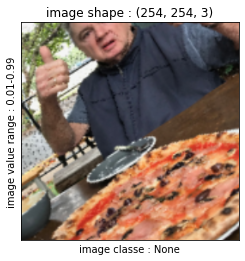

In [48]:
im = rescale_resize_and_augmentation(pizza)
plot_image(im=im)

## Multi-class Classification

1. Become one with the data (visualize, visualize, visualize...)
2. Preprocess the data (prepare it for a model)
3. Create a model (start with a baseline)
4. Fit the model
5. Evaluate the model
6. Adjust different parameters and improve model (try to beat your baseline)
7. Repeat until satisfied

![](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/misc-tensorflow-workflow-outline.png)
*The workflow we're about to go through is a slightly modified version of the above image. As you keep going through deep learning problems, you'll find the workflow above is more of an outline than a step-by-step guide.*

### 1. Import and become one with the data

Again, we've got a subset of the [Food101 dataset](https://www.kaggle.com/dansbecker/food-101). In addition to the pizza and steak images, we've pulled out another eight classes.


In [3]:
import zipfile

# Download zip file of 10_food_classes images
# See how this data was created - https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/extras/image_data_modification.ipynb
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip 

# Unzip the downloaded file
zip_ref = zipfile.ZipFile("10_food_classes_all_data.zip", "r")
zip_ref.extractall()
zip_ref.close()

--2022-10-27 09:19:04--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.4.128, 74.125.24.128, 142.251.10.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.4.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 519183241 (495M) [application/zip]
Saving to: ‘10_food_classes_all_data.zip.1’

10_food_classes_all 100%[===================>] 495.13M   216MB/s    in 2.3s    

2022-10-27 09:19:07 (216 MB/s) - ‘10_food_classes_all_data.zip.1’ saved [519183241/519183241]



In [4]:
import os
from pathlib import Path

dir = Path().cwd() / "10_food_classes_all_data"

for dirpath, dirnames, filenames in os.walk(dir):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 2 directories and 0 images in '/content/10_food_classes_all_data'.
There are 10 directories and 0 images in '/content/10_food_classes_all_data/train'.
There are 0 directories and 750 images in '/content/10_food_classes_all_data/train/steak'.
There are 0 directories and 750 images in '/content/10_food_classes_all_data/train/fried_rice'.
There are 0 directories and 750 images in '/content/10_food_classes_all_data/train/sushi'.
There are 0 directories and 750 images in '/content/10_food_classes_all_data/train/ice_cream'.
There are 0 directories and 750 images in '/content/10_food_classes_all_data/train/chicken_wings'.
There are 0 directories and 750 images in '/content/10_food_classes_all_data/train/grilled_salmon'.
There are 0 directories and 750 images in '/content/10_food_classes_all_data/train/ramen'.
There are 0 directories and 750 images in '/content/10_food_classes_all_data/train/chicken_curry'.
There are 0 directories and 750 images in '/content/10_food_classes_all_data/

In [5]:
train_dir = dir / "train"
test_dir = dir / "test"

In [52]:
all_classe = [item.name for item in train_dir.glob('*')]
class_names = np.array(sorted(all_classe))
print(class_names)

['chicken_curry' 'chicken_wings' 'fried_rice' 'grilled_salmon' 'hamburger'
 'ice_cream' 'pizza' 'ramen' 'steak' 'sushi']


In [53]:
train_classe_path = {item.name: [path for path in item.glob('*')] for item in train_dir.glob('*')}

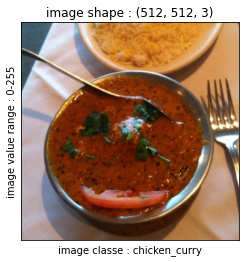

In [54]:
plot_image(path = train_classe_path[class_names[0]])

In [55]:
im_shape = []
for train_path in train_classe_path.values():
    im_shape += [min(mpimg.imread(train_path[i]).shape[0:2]) for i in range(len(train_path))]

min_im_shape_2 = min(im_shape)
min_im_shape_2

140

In [56]:
sorted(im_shape)[:10]

[140, 210, 241, 247, 252, 254, 262, 265, 273, 286]

### 2. Preprocess the data (prepare it for a model)

Time to preprocess the data.

In [6]:
from tensorflow.keras.utils import image_dataset_from_directory

full_train_set = image_dataset_from_directory(train_dir, label_mode="categorical") # by defautl convert all images to be 256 x 256
full_test_set = image_dataset_from_directory(test_dir, label_mode="categorical") # image need to be rescale, currently 0-255

Found 7500 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


`label_mode` = 'categorical' means that the labels are encoded as a categorical vector (e.g. for categorical_crossentropy loss).

[Categorical variable](https://en.wikipedia.org/wiki/Categorical_variable) :
In computer science and some branches of mathematics, categorical variables are referred to as *enumerations* (or enumerated types). Commonly, each of the possible values of a categorical variable is referred to as a level.

[Enumeration](https://en.wikipedia.org/wiki/Enumeration) :
An enumeration is a complete, ordered listing of all the items in a collection. The term is commonly used in mathematics and computer science to refer to a listing of all of the elements of a set.

In [7]:
rescale_resize_and_augmentation_2 = tf.keras.Sequential([

  tf.keras.layers.Resizing(256, 256),
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.RandomFlip("horizontal_and_vertical"),
  tf.keras.layers.RandomRotation(0.2, fill_mode="constant"), 
  tf.keras.layers.RandomZoom((-0.2, -0.4)) # A positive value means zooming out, while a negative value means zooming in

])

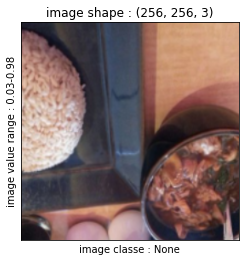

In [59]:
im = mpimg.imread(train_classe_path[class_names[0]][0])
im_edit = rescale_resize_and_augmentation_2(im)

plt.subplot(1,2,1)
plot_image(im=im_edit)

plt.subplot(1,2,2)
plot_image(im=im)

### 3. Create a model (start with a baseline)

We can use the same model (TinyVGG i.e. `model_0`) we used for the binary classification problem for our multi-class classification problem with a couple of small tweaks.

Namely:
* Changing the output layer to use have 10 ouput neurons (the same number as the number of classes we have).
* Changing the loss function to be `'categorical_crossentropy'` instead of `'binary_crossentropy'`.
* Changing the output layer to use `'softmax'` activation instead of `'sigmoid'` activation.
> reminder : $$ Softmax(i) = { exp(i) \over \sum_i^n exp(i) }$$ <br> its a "soft `argmax`"

In [60]:
tf.random.set_seed(0)

model_3 = tf.keras.Sequential([
    
    rescale_resize_and_augmentation_2,

    tf.keras.layers.Conv2D(10, (3,3), activation="relu"),
    tf.keras.layers.Conv2D(10, (3,3), activation="relu"),
    tf.keras.layers.MaxPool2D((2,2)),

    tf.keras.layers.Conv2D(10, (3,3), activation="relu"),
    tf.keras.layers.Conv2D(10, (3,3), activation="relu"),
    tf.keras.layers.MaxPool2D((2,2)),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(10, activation="softmax")

])

model_3.compile(loss="categorical_crossentropy",
                optimizer="adam",
                metrics=["accuracy"]);

In [61]:
history_3 = model_3.fit(full_train_set, epochs=10, validation_data=full_test_set)

Epoch 1/10


235/235 [==============================] - ETA: 0s - loss: 2.1679 - accuracy: 0.2077

235/235 [==============================] - 40s 158ms/step - loss: 2.1679 - accuracy: 0.2077 - val_loss: 2.0814 - val_accuracy: 0.2424
Epoch 2/10
235/235 [==============================] - 35s 145ms/step - loss: 2.0702 - accuracy: 0.2587 - val_loss: 2.0409 - val_accuracy: 0.2636
Epoch 3/10
235/235 [==============================] - 30s 124ms/step - loss: 2.0338 - accuracy: 0.2664 - val_loss: 2.0325 - val_accuracy: 0.2860
Epoch 4/10
235/235 [==============================] - 30s 127ms/step - loss: 2.0081 - accuracy: 0.2756 - val_loss: 2.0875 - val_accuracy: 0.2340
Epoch 5/10
235/235 [==============================] - 30s 124ms/step - loss: 1.9994 - accuracy: 0.2945 - val_loss: 1.9894 - val_accuracy: 0.2772
Epoch 6/10
235/235 [==============================] - 30s 125ms/step - loss: 1.9658 - accuracy: 0.3007 - val_loss: 1.9444 - val_accuracy: 0.3076
Epoch 7/10
235/235 [==============================] - 31s 129ms/step - loss: 1.9600 - accuracy: 0.3059 - val_loss: 1.9763 - val_accuracy: 0.2

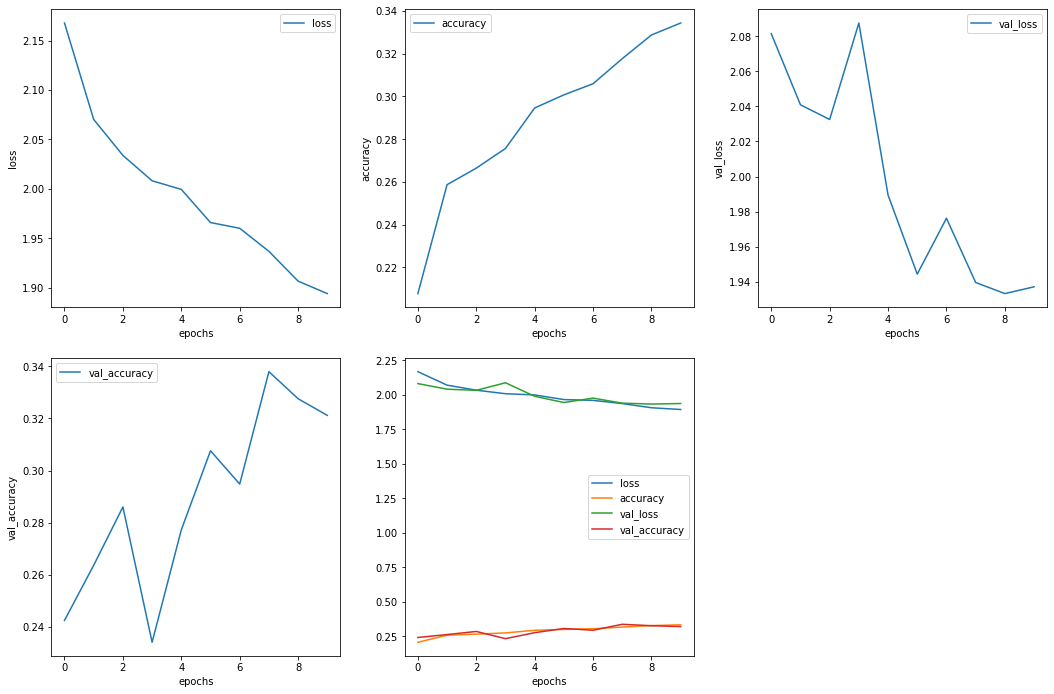

In [62]:
plot_history(history_3)

**`model_3` performe poorly but thanks to data augmentation it doesn't overfit !**

## Improve model

lets use [VGG-16 Model](https://www.analyticsvidhya.com/blog/2020/08/top-4-pre-trained-models-for-image-classification-with-python-code/)
architecture :

<br>

![](https://cdn.analyticsvidhya.com/wp-content/uploads/2020/04/vgg16-neural-network.jpg)

![](https://cdn.analyticsvidhya.com/wp-content/uploads/2020/04/VGG-2.png)

In [29]:
preprocessing_4 = tf.keras.Sequential([

  tf.keras.layers.Resizing(224, 224),
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.RandomFlip("horizontal_and_vertical"),
  tf.keras.layers.RandomRotation(0.2, fill_mode="constant"), 
  tf.keras.layers.RandomZoom((-0.2, -0.4)) # A positive value means zooming out, while a negative value means zooming in

])

In [30]:
tf.random.set_seed(0)

# Training params : 11,013,098
model_4 = tf.keras.Sequential([
    
    preprocessing_4, # im_shape : (224, 224)

    tf.keras.layers.Conv2D(64, (3,3), activation="relu", padding="same", input_shape=(224,224,3)), # im_shape : (224, 224)
    tf.keras.layers.Conv2D(64, (3,3), activation="relu", padding="same"), # im_shape : (224, 224)
    tf.keras.layers.MaxPool2D((2,2), strides=(2,2)), # im_shape : (112, 112)
    # tf.keras.layers.Dropout(0.2),

    tf.keras.layers.Conv2D(128, (3,3), activation="relu", padding="same"), # im_shape : (112, 112)
    tf.keras.layers.Conv2D(128, (3,3), activation="relu", padding="same"), # im_shape : (112, 112)
    tf.keras.layers.MaxPool2D((2,2), strides=(2,2)), # im_shape : (56, 56)
    # tf.keras.layers.Dropout(0.2),
    
    tf.keras.layers.Conv2D(256, (3,3), activation="relu", padding="same"), # im_shape : (56, 56)
    tf.keras.layers.Conv2D(256, (3,3), activation="relu", padding="same"), # im_shape : (56, 56)
    tf.keras.layers.MaxPool2D((2,2), strides=(2,2)), # im_shape : (28, 28)
    # tf.keras.layers.Dropout(0.2),

    tf.keras.layers.Conv2D(512, (3,3), activation="relu", padding="same"), # im_shape : (28, 28)
    tf.keras.layers.Conv2D(512, (3,3), activation="relu", padding="same"), # im_shape : (28, 28)
    tf.keras.layers.MaxPool2D((2,2), strides=(2,2)), # im_shape : (14, 14)
    # tf.keras.layers.Dropout(0.2),

    tf.keras.layers.Conv2D(512, (3,3), activation="relu", padding="same"), # im_shape : (14, 14)
    tf.keras.layers.Conv2D(512, (3,3), activation="relu", padding="same"), # im_shape : (14, 14)
    tf.keras.layers.MaxPool2D((2,2), strides=(2,2)), # im_shape : (7, 7)
    # tf.keras.layers.Dropout(0.2),

    tf.keras.layers.Flatten(), # shape : (49*512,)
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dense(32, activation="relu"),
    tf.keras.layers.Dense(10, activation="softmax")

])

model_4.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                metrics=["accuracy"])

In [119]:
history_4 = model_4.fit(full_train_set, epochs=10, validation_data=full_test_set)

Epoch 1/10
235/235 [==============================] - 111s 462ms/step - loss: 2.2350 - accuracy: 0.1499 - val_loss: 2.1952 - val_accuracy: 0.1632
Epoch 2/10
235/235 [==============================] - 108s 459ms/step - loss: 2.1818 - accuracy: 0.1833 - val_loss: 2.1513 - val_accuracy: 0.1868
Epoch 3/10
235/235 [==============================] - 108s 457ms/step - loss: 2.1525 - accuracy: 0.1987 - val_loss: 2.1425 - val_accuracy: 0.1904
Epoch 4/10
235/235 [==============================] - 107s 455ms/step - loss: 2.1307 - accuracy: 0.2072 - val_loss: 2.1499 - val_accuracy: 0.1888
Epoch 5/10
235/235 [==============================] - 108s 457ms/step - loss: 2.1103 - accuracy: 0.2175 - val_loss: 2.1103 - val_accuracy: 0.2144
Epoch 6/10
235/235 [==============================] - 108s 457ms/step - loss: 2.0619 - accuracy: 0.2520 - val_loss: 2.0606 - val_accuracy: 0.2536
Epoch 7/10
235/235 [==============================] - 107s 455ms/step - loss: 2.0003 - accuracy: 0.2940 - val_loss: 2.0204 -

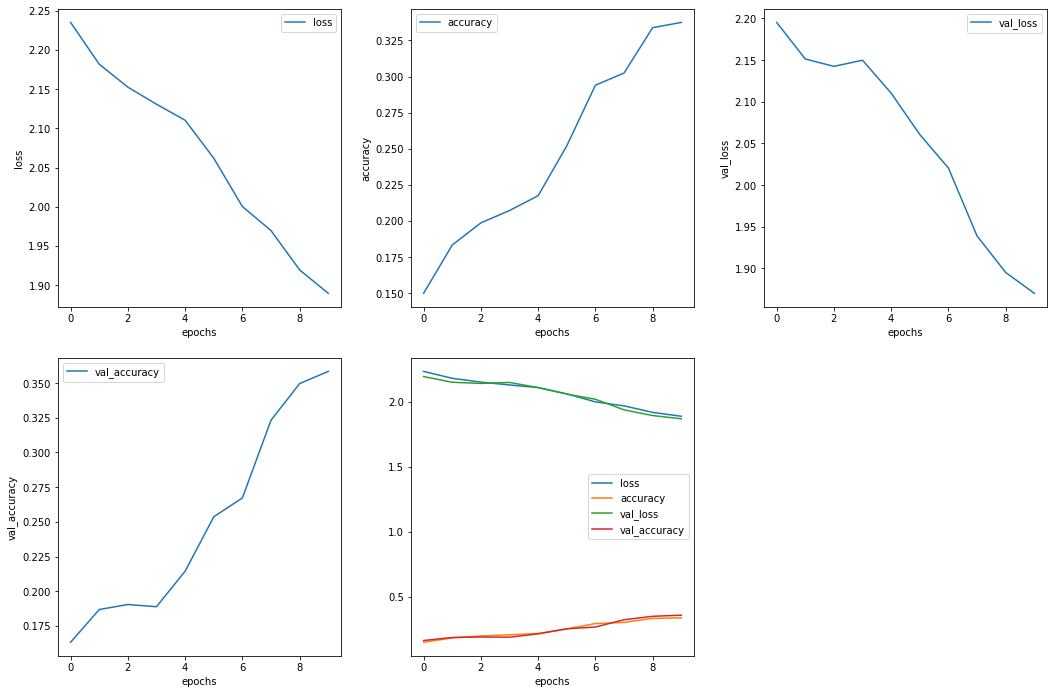

In [120]:
plot_history(history_4)

## Transfere learning with 10% data

In [10]:
# Get 10% of the data of the 10 classes
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip 

import zipfile
zip_ref = zipfile.ZipFile("10_food_classes_10_percent.zip", "r")
zip_ref.extractall()
zip_ref.close()

--2022-10-27 09:20:44--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.130.128, 142.250.4.128, 74.125.24.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.130.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip.1’

10_food_classes_10_ 100%[===================>] 160.74M   291MB/s    in 0.6s    

2022-10-27 09:20:45 (291 MB/s) - ‘10_food_classes_10_percent.zip.1’ saved [168546183/168546183]



In [11]:
from pathlib import Path

train_dir_10_percent = Path().cwd() / "10_food_classes_10_percent" / "train"
test_dir_10_percent = Path().cwd() / "10_food_classes_10_percent" / "test"

In [17]:
from tensorflow.keras.preprocessing import image_dataset_from_directory

train_set_10_percent = image_dataset_from_directory(train_dir_10_percent, label_mode="categorical", image_size=(256,256)) 
test_set_10_percent = image_dataset_from_directory(test_dir_10_percent, label_mode="categorical", image_size=(256,256)) 

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [23]:
preprocessing_vgg = tf.keras.Sequential([

  tf.keras.layers.Resizing(256, 256),
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.RandomFlip("horizontal_and_vertical"),
  tf.keras.layers.RandomRotation(0.2, fill_mode="constant"), 
  tf.keras.layers.RandomZoom((-0.2, -0.2)) # A positive value means zooming out, while a negative value means zooming in

])

In [24]:
from keras.applications.vgg16 import VGG16

# Modele VGG16
base_model = VGG16(weights='imagenet', include_top=False) 
# Freeze VGG16 layer
base_model.trainable = False

model_vgg = tf.keras.Sequential([
    tf.keras.Input((256,256,3)),
    preprocessing_vgg,
    base_model,
    # tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(10, activation='softmax')
])

model_vgg.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])

In [25]:
history_vgg = model_vgg.fit(train_set_10_percent, epochs=10)

Epoch 1/10
24/24 [==============================] - 7s 228ms/step - loss: 3.0629 - acc: 0.2120
Epoch 2/10
24/24 [==============================] - 6s 228ms/step - loss: 1.9889 - acc: 0.3733
Epoch 3/10
24/24 [==============================] - 6s 229ms/step - loss: 1.6071 - acc: 0.4707
Epoch 4/10
24/24 [==============================] - 6s 228ms/step - loss: 1.3135 - acc: 0.5587
Epoch 5/10
24/24 [==============================] - 6s 244ms/step - loss: 1.3697 - acc: 0.5547
Epoch 6/10
24/24 [==============================] - 8s 266ms/step - loss: 1.1392 - acc: 0.6427
Epoch 7/10
24/24 [==============================] - 7s 243ms/step - loss: 1.0535 - acc: 0.6347
Epoch 8/10
24/24 [==============================] - 6s 230ms/step - loss: 0.9742 - acc: 0.6720
Epoch 9/10
24/24 [==============================] - 6s 228ms/step - loss: 0.8678 - acc: 0.7120
Epoch 10/10
24/24 [==============================] - 6s 227ms/step - loss: 0.8131 - acc: 0.7347


In [26]:
model_vgg.evaluate(test_set_10_percent)

79/79 [==============================] - 16s 198ms/step - loss: 1.7361 - acc: 0.4844


[1.736052393913269, 0.4844000041484833]

## Try with 10% of the data

In [38]:
model_5 = tf.keras.models.clone_model(model_4)

model_5.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                metrics=["acc"])

In [39]:
history_5 = model_5.fit(train_set_10_percent,
                        epochs=10)

Epoch 1/10
24/24 [==============================] - 11s 383ms/step - loss: 2.3033 - acc: 0.0853
Epoch 2/10
24/24 [==============================] - 10s 383ms/step - loss: 2.3005 - acc: 0.1000
Epoch 3/10
24/24 [==============================] - 10s 385ms/step - loss: 2.3007 - acc: 0.1133
Epoch 4/10
24/24 [==============================] - 10s 385ms/step - loss: 2.2855 - acc: 0.1107
Epoch 5/10
24/24 [==============================] - 10s 379ms/step - loss: 2.3029 - acc: 0.1000
Epoch 6/10
24/24 [==============================] - 10s 383ms/step - loss: 2.3024 - acc: 0.1027
Epoch 7/10
24/24 [==============================] - 10s 388ms/step - loss: 2.3022 - acc: 0.0973
Epoch 8/10
24/24 [==============================] - 9s 376ms/step - loss: 2.3024 - acc: 0.1013
Epoch 9/10
24/24 [==============================] - 10s 379ms/step - loss: 2.2990 - acc: 0.1160
Epoch 10/10
24/24 [==============================] - 10s 380ms/step - loss: 2.2919 - acc: 0.1347


In [40]:
model_5.evaluate(test_set_10_percent)

79/79 [==============================] - 11s 132ms/step - loss: 2.2561 - acc: 0.1588


[2.256082534790039, 0.15880000591278076]

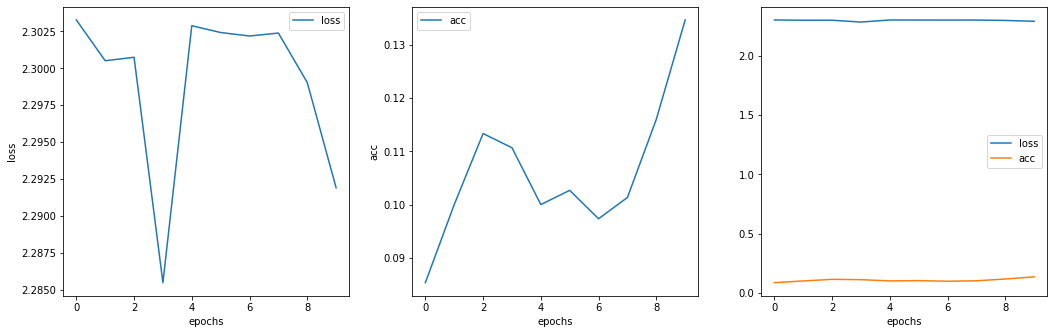

In [41]:
plot_history(history_5)

# 📖 Extra-curriculum

1. **Watch:** [MIT's Introduction to Deep Computer Vision](https://www.youtube.com/watch?v=iaSUYvmCekI&list=PLtBw6njQRU-rwp5__7C0oIVt26ZgjG9NI&index=3) lecture. This will give you a great intuition behind convolutional neural networks.

2. **Watch:** Deep dive on [mini-batch gradient descent](https://youtu.be/-_4Zi8fCZO4) by deeplearning.ai. If you're still curious about why we use **batches** to train models, this technical overview covers many of the reasons why.

3. **Read:** [CS231n Convolutional Neural Networks for Visual Recognition](https://cs231n.github.io/convolutional-networks/) class notes. This will give a very deep understanding of what's going on behind the scenes of the convolutional neural network architectures we're writing. 

4. **Read:** ["A guide to convolution arithmetic for deep learning"](https://arxiv.org/pdf/1603.07285.pdf). This paper goes through all of the mathematics running behind the scenes of our convolutional layers.

5. **Code practice:** [TensorFlow Data Augmentation Tutorial](https://www.tensorflow.org/tutorials/images/data_augmentation). For a more in-depth introduction on data augmentation with TensorFlow, spend an hour or two reading through this tutorial.